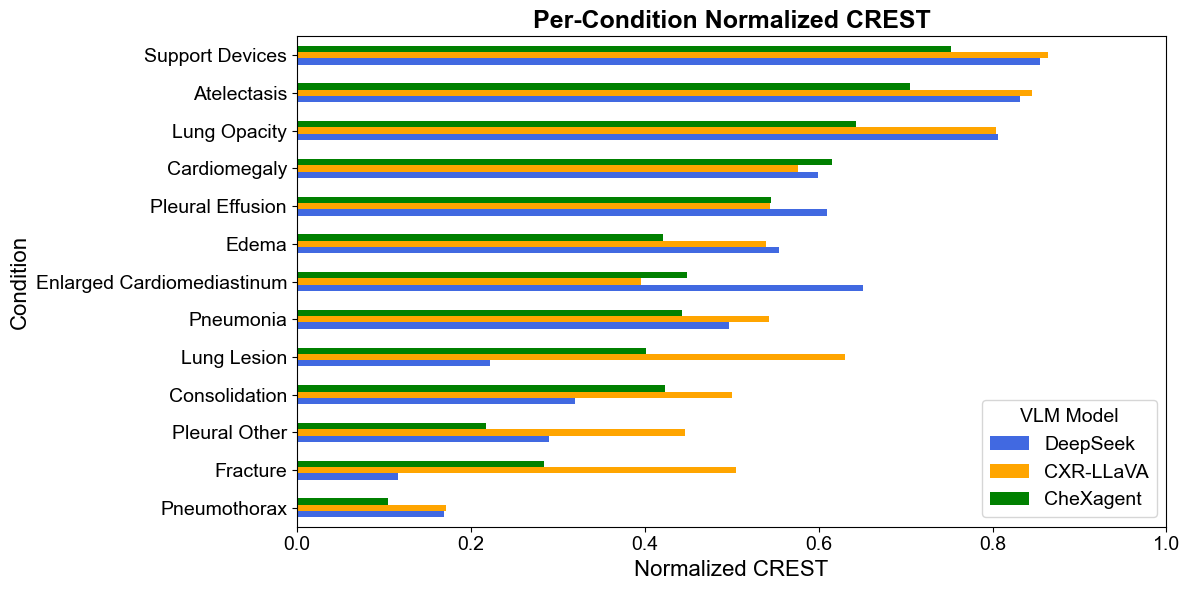

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
# Set global font to Arial
matplotlib.rcParams["font.family"] = "Arial"

# Load prediction and gold standard files
file_gold = "mimic-cxr-gold-standard.xlsx"
file_deepseek = "labels_DeepSeek_fixed.xlsx"
file_cxr_llava = "labels_CXR_LLaVA_fixed.xlsx"
file_cxr_chexagent = "labels_cheXagent_fixed.xlsx"

df_gold = pd.read_excel(file_gold)
df_deepseek = pd.read_excel(file_deepseek)
df_cxr_llava = pd.read_excel(file_cxr_llava)
df_cxr_chexagent = pd.read_excel(file_cxr_chexagent)

# Define condition list
conditions = [
    "Enlarged Cardiomediastinum", "Cardiomegaly", "Lung Lesion",
    "Lung Opacity", "Edema", "Consolidation", "Pneumonia",
    "Atelectasis", "Pneumothorax", "Pleural Effusion", "Pleural Other",
    "Fracture", "Support Devices"
]

# Fill NaNs
for df in [df_gold, df_deepseek, df_cxr_llava, df_cxr_chexagent]:
    df[conditions] = df[conditions].fillna(-2).astype(int)

# Error types and risk levels
error_types = {
    (1, 0):  "False Negative (Wrong Negation): 1 → 0",
    (1, -1): "False Negative (Uncertainty Downgrade): 1 → -1",
    (1, -2): "Omission (Missed Finding): 1 → -2",
    (0, 1):  "False Positive (Wrong Affirmation): 0 → 1",
    (0, -1): "False Positive (Uncertainty Introduction): 0 → -1",
    (0, -2): "Omission (Removed Negative Evidence): 0 → -2",
    (-2, 1): "Hallucination (Nonexistent Condition): -2 → 1",
    (-2, 0): "False Certainty (Wrong Negation): -2 → 0",
    (-2, -1): "False Certainty (Incorrect Uncertainty): -2 → -1",
    (-1, 1): "Uncertainty Overconfidence (False Positive): -1 → 1",
    (-1, 0): "Uncertainty Underconfidence (False Negative): -1 → 0",
    (-1, -2): "Uncertainty Omission (Dropped Finding): -1 → -2",
}

risk_levels = {
    "False Negative (Wrong Negation)": "High",
    "False Negative (Uncertainty Downgrade)": "High",
    "Omission (Missed Finding)": "High",
    "False Positive (Wrong Affirmation)": "Medium",
    "False Positive (Uncertainty Introduction)": "Medium",
    "Omission (Removed Negative Evidence)": "Low",
    "Hallucination (Nonexistent Condition)": "High",
    "False Certainty (Wrong Negation)": "Low",
    "False Certainty (Incorrect Uncertainty)": "Medium",
    "Uncertainty Overconfidence (False Positive)": "Medium",
    "Uncertainty Underconfidence (False Negative)": "High",
    "Uncertainty Omission (Dropped Finding)": "High"
}

risk_scores = {"Low": 1, "Medium": 2, "High": 3}

models = {
    "DeepSeek": df_deepseek,
    "CXR-LLaVA": df_cxr_llava,
    "CheXagent": df_cxr_chexagent
}

# Compute normalized crest per condition for each model
per_condition_crest = {cond: {} for cond in conditions}

for cond in conditions:
    for model_name, df_pred in models.items():
        total_risk = 0
        total_errors = 0
        for gt, pred in zip(df_gold[cond], df_pred[cond]):
            if (gt, pred) in error_types:
                error_desc = error_types[(gt, pred)]
                risk_name = error_desc.split(":")[0]
                risk_level = risk_levels[risk_name]
                score = risk_scores[risk_level]
                total_risk += score
                total_errors += 1
        crest = total_risk / total_errors if total_errors > 0 else 0
        norm_crest = (crest - 1) / 2 if crest > 0 else 0
        per_condition_crest[cond][model_name] = norm_crest

# Plotting
df_crest_cond = pd.DataFrame(per_condition_crest).T[["DeepSeek", "CXR-LLaVA", "CheXagent"]]
#df_crest_cond_sorted = df_crest_cond.sort_values(by="DeepSeek", ascending=True)
df_crest_cond_sorted = df_crest_cond.copy()
df_crest_cond_sorted["Mean"] = df_crest_cond_sorted.mean(axis=1)
df_crest_cond_sorted = df_crest_cond_sorted.sort_values(by="Mean").drop(columns="Mean")

ax = df_crest_cond_sorted.plot(kind="barh", figsize=(12, 6), color=["royalblue", "orange", "green"])

ax.set_xlabel("Normalized CREST", fontsize=16)
ax.set_ylabel("Condition", fontsize=16)
ax.set_title("Per-Condition Normalized CREST", fontsize=18, fontweight="bold")
ax.tick_params(labelsize=14)
ax.tick_params(labelsize=14)
ax.legend(title="VLM Model", fontsize=14, title_fontsize=14, loc='lower right', frameon=True)
plt.xlim(0, 1)
plt.tight_layout()
plt.savefig("per_condition_norm_crest.png", dpi=300, bbox_inches="tight")
plt.savefig("per_condition_norm_crest.pdf", dpi=300, bbox_inches="tight")
plt.show()


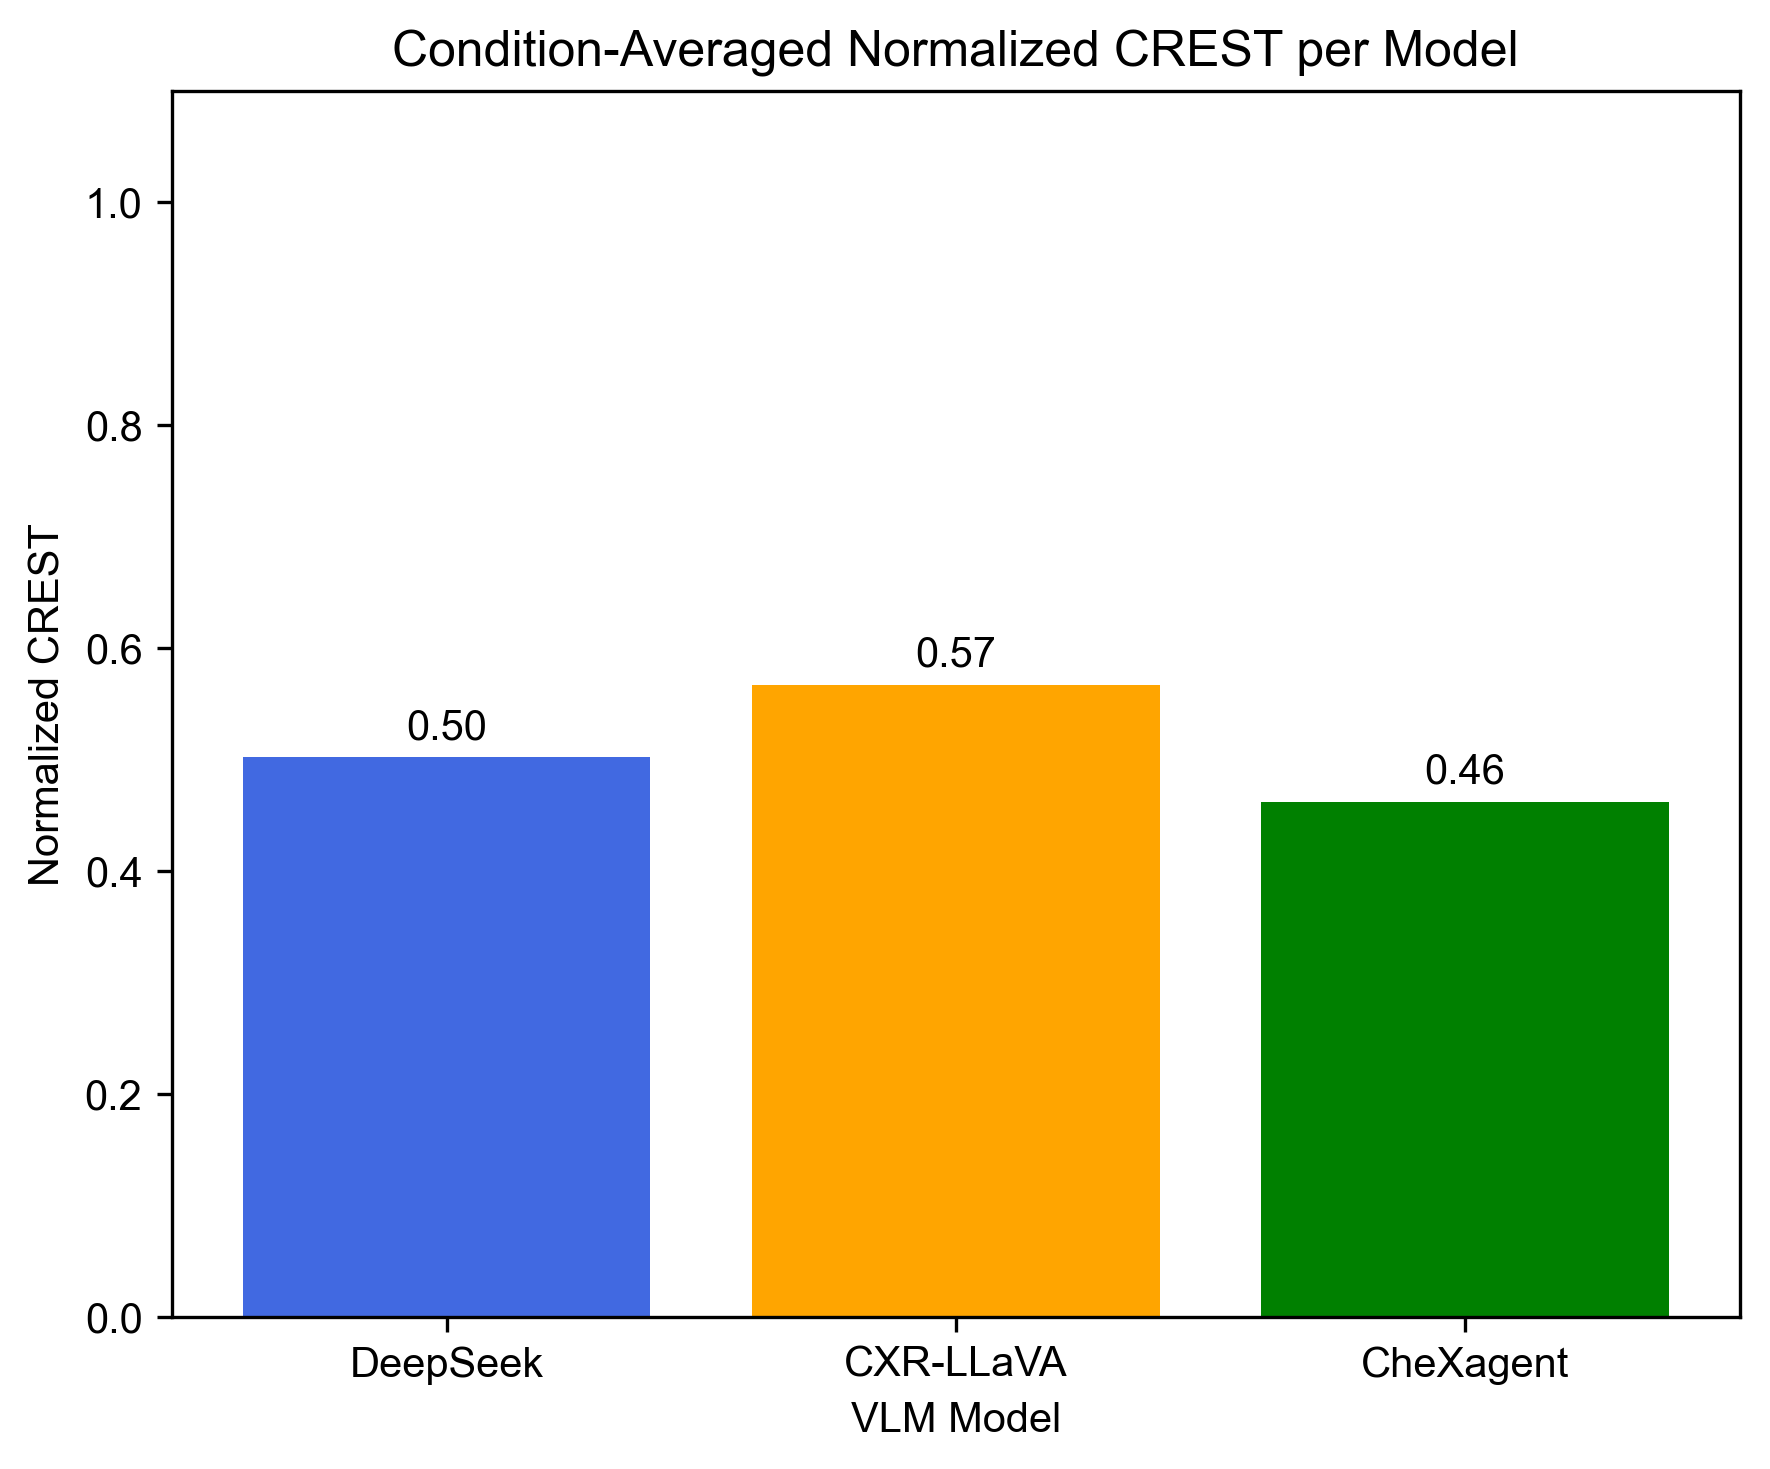

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load Excel files
df_gold = pd.read_excel("mimic-cxr-gold-standard.xlsx")
df_deepseek = pd.read_excel("labels_DeepSeek_fixed.xlsx")
df_cxr_llava = pd.read_excel("labels_CXR_LLaVA_fixed.xlsx")
df_cxr_chexagent = pd.read_excel("labels_cheXagent_fixed.xlsx")

# Define clinical conditions
conditions = [
    "Enlarged Cardiomediastinum", "Cardiomegaly", "Lung Lesion",
    "Lung Opacity", "Edema", "Consolidation", "Pneumonia",
    "Atelectasis", "Pneumothorax", "Pleural Effusion", "Pleural Other",
    "Fracture", "Support Devices"
]

# Fill missing values with -2 ("not mentioned")
for df in [df_gold, df_deepseek, df_cxr_llava, df_cxr_chexagent]:
    df[conditions] = df[conditions].fillna(-2).astype(int)

# Define error types
error_types = {
    (1, 0):  "False Negative (Wrong Negation): 1 → 0",
    (1, -1): "False Negative (Uncertainty Downgrade): 1 → -1",
    (1, -2): "Omission (Missed Finding): 1 → -2",
    (0, 1):  "False Positive (Wrong Affirmation): 0 → 1",
    (0, -1): "False Positive (Uncertainty Introduction): 0 → -1",
    (0, -2): "Omission (Removed Negative Evidence): 0 → -2",
    (-2, 1): "Hallucination (Nonexistent Condition): -2 → 1",
    (-2, 0): "False Certainty (Wrong Negation): -2 → 0",
    (-2, -1): "False Certainty (Incorrect Uncertainty): -2 → -1",
    (-1, 1): "Uncertainty Overconfidence (False Positive): -1 → 1",
    (-1, 0): "Uncertainty Underconfidence (False Negative): -1 → 0",
    (-1, -2): "Uncertainty Omission (Dropped Finding): -1 → -2",
}

# Assign clinical risk levels
risk_levels = {
    "False Negative (Wrong Negation)": "High",
    "False Negative (Uncertainty Downgrade)": "High",
    "Omission (Missed Finding)": "High",
    "False Positive (Wrong Affirmation)": "Medium",
    "False Positive (Uncertainty Introduction)": "Medium",
    "Omission (Removed Negative Evidence)": "Low",
    "Hallucination (Nonexistent Condition)": "High",
    "False Certainty (Wrong Negation)": "Low",
    "False Certainty (Incorrect Uncertainty)": "Medium",
    "Uncertainty Overconfidence (False Positive)": "Medium",
    "Uncertainty Underconfidence (False Negative)": "High",
    "Uncertainty Omission (Dropped Finding)": "High"
}

# Numerical scores
risk_scores = {"Low": 1, "Medium": 2, "High": 3}

# Model dictionary
models = {
    "DeepSeek": df_deepseek,
    "CXR-LLaVA": df_cxr_llava,
    "CheXagent": df_cxr_chexagent
}

# Step 1: Compute normalized CREST per condition per model
per_condition_crest = {model: {} for model in models}

for model_name, df_pred in models.items():
    for cond in conditions:
        total_risk = 0
        total_errors = 0
        for gt, pred in zip(df_gold[cond], df_pred[cond]):
            if (gt, pred) in error_types:
                error_desc = error_types[(gt, pred)]
                risk_name = error_desc.split(":")[0]
                risk_level = risk_levels[risk_name]
                score = risk_scores[risk_level]
                total_risk += score
                total_errors += 1
        if total_errors > 0:
            crest = total_risk / total_errors
            norm_crest = (crest - 1) / 2  # Normalize to [0, 1]
            per_condition_crest[model_name][cond] = norm_crest
        else:
            per_condition_crest[model_name][cond] = None

# Step 2: Macro-average per-condition CREST across conditions
macro_avg_crest = {}
for model, cond_scores in per_condition_crest.items():
    valid_scores = [v for v in cond_scores.values() if v is not None]
    macro_avg = sum(valid_scores) / len(valid_scores)
    macro_avg_crest[model] = macro_avg

# Step 3: Plot bar chart
plt.figure(figsize=(6, 5), dpi=300)
colors = ["royalblue", "orange", "green"]
bars = plt.bar(macro_avg_crest.keys(), macro_avg_crest.values(), color=colors)

# Add value labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom')

# Formatting
plt.title("Condition-Averaged Normalized CREST per Model")
plt.xlabel("VLM Model")
plt.ylabel("Normalized CREST")
plt.ylim(0, 1.1)
plt.tight_layout()

# Save
plt.savefig("macro_avg_norm_crest.png", dpi=300, bbox_inches="tight")
plt.savefig("macro_avg_norm_crest.pdf", bbox_inches="tight")
plt.show()
